In [30]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import json

# Use an *r-string* to avoid issues with backslashes
file_path = r"C:\Users\Phong\OneDrive\DOCUME~1\VSCODE~1\CMPUT6~1\Analysis\ENV_AN~1.JSO"

try:
    with open(file_path, "r") as f:
        data = json.load(f)
    print("✅ Successfully loaded JSON data!")
except FileNotFoundError:
    print(f"❌ File not found at: {file_path}")


✅ Successfully loaded JSON data!


In [24]:
events = data["events"]

train_events = []
for e in events:
    if e["event"] == "train_episode":
        train_events.append(e)

In [ ]:
# Create empty lists to store the values we want
steps = []
avg_returns = []

# Loop through every training episode and pull out the total_steps and average_return
for e in train_events:
    total_steps = e["total_steps"]
    average_return = e["average_return"]

    steps.append(total_steps)
    avg_returns.append(average_return)


In [28]:
def smooth_curve(values, window_size):
    """
    Smooths a list or array of values using a simple moving average.

    Args:
        values (list or np.array): sequence of numbers to smooth
        window_size (int): number of points to average over

    Returns:
        np.array: smoothed version of the input sequence
    """
    if len(values) < window_size:
        return np.array(values)  # not enough data to smooth

    values = np.array(values, dtype=float)
    kernel = np.ones(window_size) / window_size
    smoothed = np.convolve(values, kernel, mode="same")
    return smoothed


In [ ]:
# Downsample to make plotting faster (optional)
# For example, take every 50th point
downsample_rate = 50
steps_downsampled = steps[::downsample_rate]
returns_downsampled = avg_returns[::downsample_rate]

# Smooth the curve
smoothed_returns = smooth_curve(returns_downsampled, window_size=100)


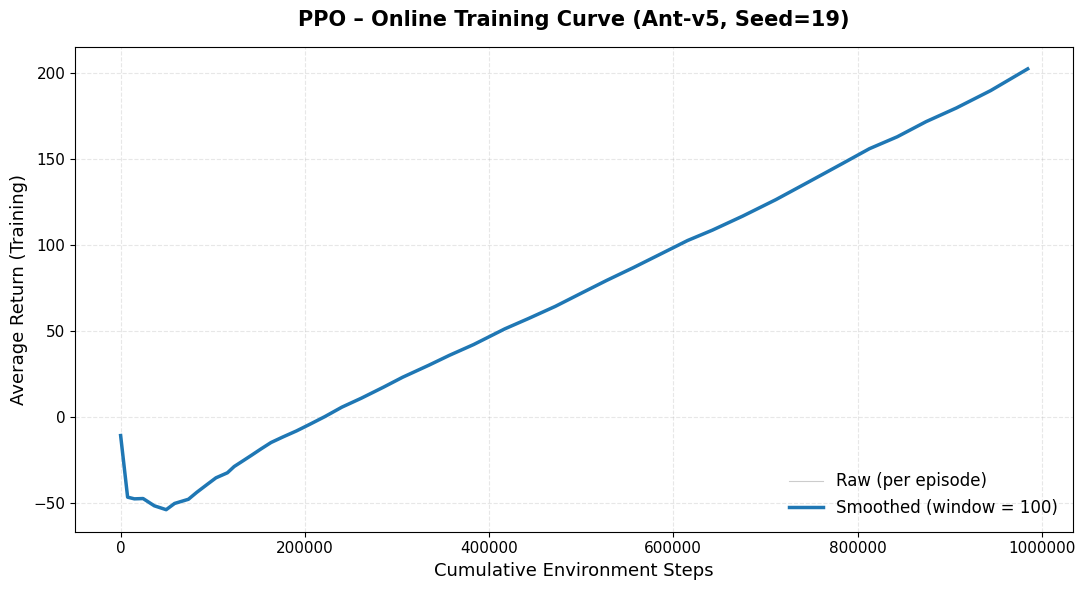

In [40]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# ==========================================================
# STEP: Pretty Plot of Online Training Curve
# ==========================================================
plt.figure(figsize=(11, 6))

# Raw (light gray, slightly transparent)
plt.plot(
    steps_downsampled,
    returns_downsampled,
    color="gray",
    linewidth=0.8,
    alpha=0.4,
    label="Raw (per episode)"
)

# Smoothed curve (blue, bold)
plt.plot(
    steps_downsampled,
    smoothed_returns,
    color="#1f77b4",      # soft blue
    linewidth=2.5,
    label="Smoothed (window = 100)"
)

# ----------------------------------------------------------
# Aesthetics
# ----------------------------------------------------------
plt.title("PPO – Online Training Curve (Ant-v5, Seed=19)",
          fontsize=15, weight='bold', pad=15)

plt.xlabel("Cumulative Environment Steps", fontsize=13)
plt.ylabel("Average Return (Training)", fontsize=13)

plt.grid(alpha=0.3, linestyle="--")

# Keep full numbers (no 1e5 notation)
ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.ticklabel_format(style='plain', axis='x')
plt.tick_params(axis='both', labelsize=11)

# Legend styling
plt.legend(frameon=False, fontsize=12, loc="lower right")

# Add slight padding so title and axes don’t touch edges
plt.tight_layout()

# Optional background color for a clean look
plt.gcf().patch.set_facecolor('white')

plt.show()


✅ Folder exists!
Found 33 total items in the folder:
    a1.ipynb
    env=Ant-v5__algo=ppo__phase=train__seed=19__clip_param=0.2__gamma=0.99__lam=0.97__policy_lr=0.0003__sample_size=2048__target_kl=0.01__train_policy_iters=10__train_vf_iters=10__vf_lr=0.0003.json
    env=Ant-v5__algo=ppo__phase=train__seed=19__clip_param=0.2__gamma=0.99__lam=0.97__policy_lr=0.0003__sample_size=2048__target_kl=0.01__train_policy_iters=10__train_vf_iters=20__vf_lr=0.0003.json
    env=Ant-v5__algo=ppo__phase=train__seed=19__clip_param=0.2__gamma=0.99__lam=0.97__policy_lr=0.0003__sample_size=2048__target_kl=0.01__train_policy_iters=20__train_vf_iters=10__vf_lr=0.0003.json
    env=Ant-v5__algo=ppo__phase=train__seed=19__clip_param=0.2__gamma=0.99__lam=0.97__policy_lr=0.0003__sample_size=2048__target_kl=0.01__train_policy_iters=20__train_vf_iters=20__vf_lr=0.0003.json
    env=Ant-v5__algo=ppo__phase=train__seed=19__clip_param=0.2__gamma=0.99__lam=0.97__policy_lr=0.0003__sample_size=2048__target_kl=0.02__trai

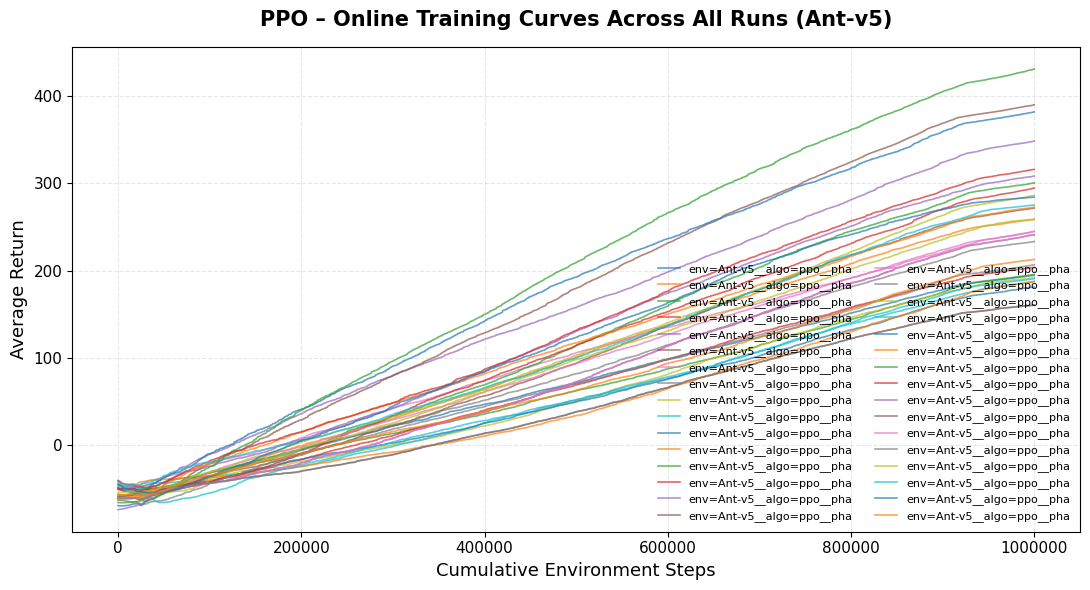

In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# ==========================================================
# 1️⃣ Folder path — Fixed for Windows Long Path Limit
# ==========================================================
# Your original path:
original_folder_path = r"C:/Users/Phong/OneDrive/Documents/VSCODEFILE/CMPUT665-PROJECT/Analysis"

# This adds the Windows "long path aware" prefix (\\?\)
# This is the corrected line to fix the SyntaxError
folder = r"\\?\\" + os.path.abspath(original_folder_path)

# ==========================================================
# 2️⃣ Check that folder exists and list its contents
# ==========================================================
if not os.path.exists(folder):
    raise FileNotFoundError(f"❌ Folder not found: {folder}\nCheck that the path is correct.")
else:
    print("✅ Folder exists!")
    items = os.listdir(folder)
    print(f"Found {len(items)} total items in the folder:")
    for name in items[:15]:  # show first 15
        print("   ", name)

# ==========================================================
# 3️⃣ Collect .jso / .json files (case-insensitive)
# ==========================================================
files = [os.path.join(folder, f) for f in items if f.lower().endswith((".jso", ".json"))]

print(f"\n✅ Found {len(files)} training logs to process.\n")
if len(files) == 0:
    raise FileNotFoundError("No .jso or .json files found — check file extensions or folder contents.")

# ==========================================================
# 4️⃣ Helper functions
# ==========================================================
def load_training_curve(file_path):
    """Load one PPO training log and extract step + return arrays."""
    with open(file_path, "r") as f:
        data = json.load(f)

    events = data.get("events", [])
    train_events = [e for e in events if e.get("event") == "train_episode"]

    steps = [e.get("total_steps", 0) for e in train_events]
    avg_returns = [e.get("average_return", np.nan) for e in train_events]
    return np.array(steps), np.array(avg_returns)

def smooth_curve(values, window_size=200):
    """Simple moving average that keeps same array length."""
    if len(values) < window_size:
        return np.array(values)
    values = np.array(values, dtype=float)
    smoothed = np.copy(values)
    half = window_size // 2
    for i in range(len(values)):
        start = max(0, i - half)
        end = min(len(values), i + half)
        smoothed[i] = np.mean(values[start:end])
    return smoothed

# ==========================================================
# 5️⃣ Plot all runs (each as one line)
# ==========================================================
plt.figure(figsize=(11, 6))

for path in files:
    try:
        steps, avg_returns = load_training_curve(path)
        if len(steps) == 0:
            print(f"⚠️ Skipped {path}: no train_episode events.")
            continue
        smoothed_returns = smooth_curve(avg_returns, 200)
        # Use a shorter label based on the original (non-prefixed) path
        short_label = os.path.basename(path)[:25] 
        plt.plot(steps, smoothed_returns, linewidth=1.2, alpha=0.7, label=short_label)
    except Exception as e:
        print(f"⚠️ Skipped {path}: {e}")

# ==========================================================
# 6️⃣ Clean, professional plot styling
# ==========================================================
plt.title("PPO – Online Training Curves Across All Runs (Ant-v5)",
          fontsize=15, weight='bold', pad=15)
plt.xlabel("Cumulative Environment Steps", fontsize=13)
plt.ylabel("Average Return", fontsize=13)
plt.grid(alpha=0.3, linestyle="--")

ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.ticklabel_format(style='plain', axis='x')
plt.tick_params(axis='both', labelsize=11)

plt.legend(frameon=False, fontsize=8, loc="lower right", ncol=2)
plt.tight_layout()
plt.show()

✅ Folder exists!
Found 33 total items in the folder.
    a1.ipynb
    env=Ant-v5__algo=ppo__phase=train__seed=19__clip_param=0.2__gamma=0.99__lam=0.97__policy_lr=0.0003__sample_size=2048__target_kl=0.01__train_policy_iters=10__train_vf_iters=10__vf_lr=0.0003.json
    env=Ant-v5__algo=ppo__phase=train__seed=19__clip_param=0.2__gamma=0.99__lam=0.97__policy_lr=0.0003__sample_size=2048__target_kl=0.01__train_policy_iters=10__train_vf_iters=20__vf_lr=0.0003.json
    env=Ant-v5__algo=ppo__phase=train__seed=19__clip_param=0.2__gamma=0.99__lam=0.97__policy_lr=0.0003__sample_size=2048__target_kl=0.01__train_policy_iters=20__train_vf_iters=10__vf_lr=0.0003.json
    env=Ant-v5__algo=ppo__phase=train__seed=19__clip_param=0.2__gamma=0.99__lam=0.97__policy_lr=0.0003__sample_size=2048__target_kl=0.01__train_policy_iters=20__train_vf_iters=20__vf_lr=0.0003.json
    env=Ant-v5__algo=ppo__phase=train__seed=19__clip_param=0.2__gamma=0.99__lam=0.97__policy_lr=0.0003__sample_size=2048__target_kl=0.02__trai

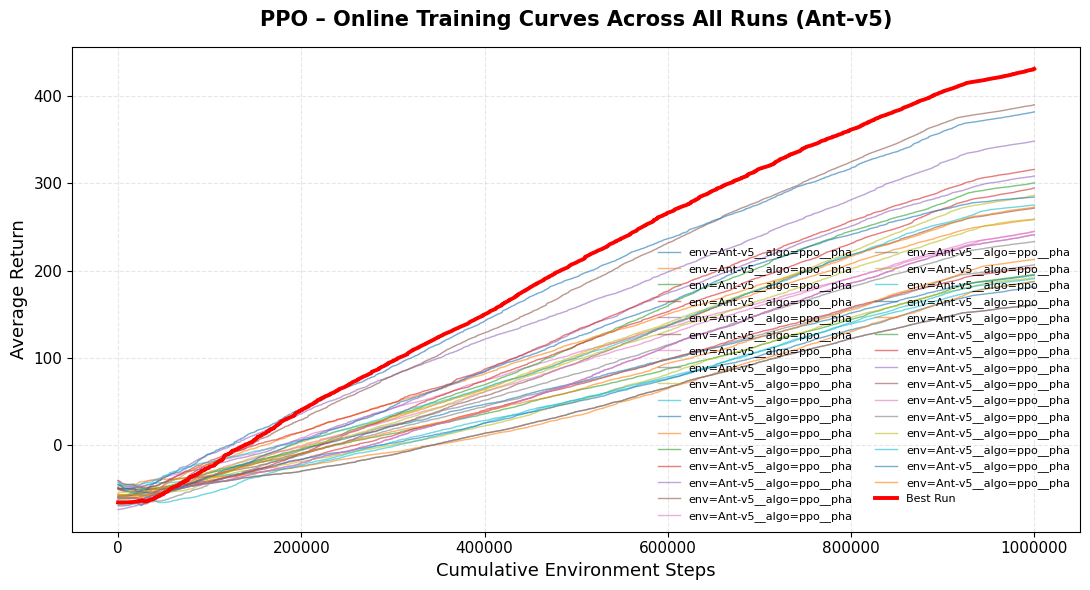

In [5]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# ==========================================================
# 1️⃣ Folder path — Fixed for Windows Long Path Limit
# ==========================================================
original_folder_path = r"C:/Users/Phong/OneDrive/Documents/VSCODEFILE/CMPUT665-PROJECT/Analysis"
folder = r"\\?\\" + os.path.abspath(original_folder_path)

# ==========================================================
# 2️⃣ Check that folder exists and list its contents
# ==========================================================
if not os.path.exists(folder):
    raise FileNotFoundError(f"❌ Folder not found: {folder}")
else:
    print("✅ Folder exists!")
    items = os.listdir(folder)
    print(f"Found {len(items)} total items in the folder.")
    for name in items[:10]:
        print("   ", name)

# ==========================================================
# 3️⃣ Collect .jso / .json files (case-insensitive)
# ==========================================================
files = [os.path.join(folder, f) for f in items if f.lower().endswith((".jso", ".json"))]
print(f"\n✅ Found {len(files)} training logs to process.\n")
if not files:
    raise FileNotFoundError("No .jso or .json files found — check folder contents.")

# ==========================================================
# 4️⃣ Helper functions
# ==========================================================
def load_training_curve(file_path):
    """Load one PPO training log and extract step + return arrays."""
    with open(file_path, "r") as f:
        data = json.load(f)
    events = data.get("events", [])
    train_events = [e for e in events if e.get("event") == "train_episode"]
    steps = [e.get("total_steps", 0) for e in train_events]
    avg_returns = [e.get("average_return", np.nan) for e in train_events]
    return np.array(steps), np.array(avg_returns)

def smooth_curve(values, window_size=200):
    """Simple moving average that keeps same array length."""
    if len(values) < window_size:
        return np.array(values)
    values = np.array(values, dtype=float)
    smoothed = np.copy(values)
    half = window_size // 2
    for i in range(len(values)):
        start = max(0, i - half)
        end = min(len(values), i + half)
        smoothed[i] = np.mean(values[start:end])
    return smoothed

# ==========================================================
# 5️⃣ Load, smooth, and plot all runs
# ==========================================================
plt.figure(figsize=(11, 6))
all_curves = []
all_paths = []

for path in files:
    try:
        steps, avg_returns = load_training_curve(path)
        if len(steps) == 0:
            print(f"⚠️ Skipped {path}: no train_episode events.")
            continue
        smoothed_returns = smooth_curve(avg_returns, 200)
        all_curves.append((steps, smoothed_returns))
        all_paths.append(path)
        short_label = os.path.basename(path)[:25]
        plt.plot(steps, smoothed_returns, linewidth=1.0, alpha=0.6, label=short_label)
    except Exception as e:
        print(f"⚠️ Skipped {path}: {e}")

# ==========================================================
# 6️⃣ Find the best-performing run
# ==========================================================
best_path, best_score = None, -np.inf
for path, (steps, returns) in zip(all_paths, all_curves):
    if len(returns) > 10:
        score = np.nanmean(returns[-10:])  # mean of last 10 values
    else:
        score = np.nanmean(returns)
    if score > best_score:
        best_score = score
        best_path = path

print("\n🏆 Best-performing run:")
print(f"Path: {best_path}")
print(f"Mean final return (last 10 pts): {best_score:.2f}")

# ==========================================================
# 7️⃣ Overlay best run (red, bold)
# ==========================================================
if best_path is not None:
    steps, avg_returns = load_training_curve(best_path)
    best_smoothed = smooth_curve(avg_returns, 200)
    plt.plot(
        steps, best_smoothed,
        color="red", linewidth=2.8, label="Best Run", zorder=5
    )

# ==========================================================
# 8️⃣ Plot styling
# ==========================================================
plt.title("PPO – Online Training Curves Across All Runs (Ant-v5)",
          fontsize=15, weight='bold', pad=15)
plt.xlabel("Cumulative Environment Steps", fontsize=13)
plt.ylabel("Average Return", fontsize=13)
plt.grid(alpha=0.3, linestyle="--")

ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax.ticklabel_format(style='plain', axis='x')
plt.tick_params(axis='both', labelsize=11)
plt.legend(frameon=False, fontsize=8, loc="lower right", ncol=2)
plt.tight_layout()
plt.show()
